# Trasformazioni geometriche

## Una breve definizione:
### Una trasformazione geometrica piana è una funzione biiettiva del piano in sé, ossia una corrispondenza biunivica che associa punti del piano a punti del piano stesso.

Per intenderci, indicato con Ω l'insieme dei punti del piano, una trasformazione geometrica piana è una funzione da Ω in Ω che ad un punto P del piano associa un altro punto P' del piano detto immagine di P tramite la trasformazione. Tale funzione è biiettiva, ovvero per ogni punto P' del piano esiste uno e un solo punto P di cui P' è immagine tramite f.

### Di seguito le trasformazioni che tratteremo, con rispettive matrici.


Rotazione =
$ \begin{bmatrix} \cos(\beta) & -\sin(\beta) & 0\\ \sin(\beta) & \cos(\beta) & 0\\ 0 & 0 & 1\\ \end{bmatrix} $ 

Ingrandimento =
$ \begin{bmatrix} sx & 0 & 0\\ 0 & sy & 0\\ 0 & 0 & 1\\ \end{bmatrix} $

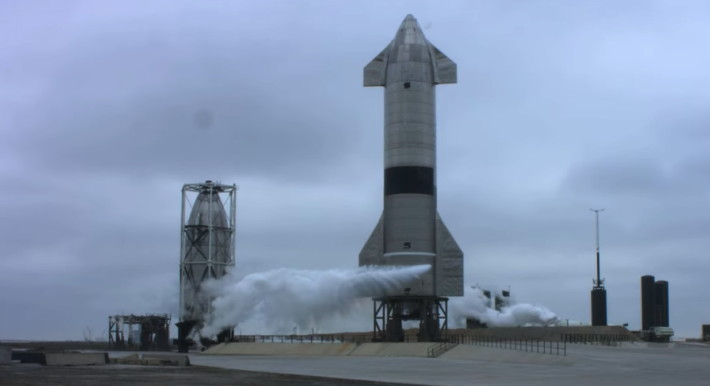

In [15]:
import numpy as np
from PIL import Image
import math
import time

original_img = Image.open("Starship.png")
image = np.array(original_img)
original_img

# Rotazione

Sopra abbiamo l'immagine originale che vogliamo ruotare di un angolo beta (45°), per prima cosa dobbiamo tenere a mente che l'immagine anche se ruotata dovrà stare all'interno di una cornice più grande della precedente e per calcolare le nuove dimensioni ci viene in aiuto il primo teorema trigonometrico sul triangolo rettangolo

<!-- ![Alt Text](image path "title") -->
![Alt Text](./img/trig.png "Optional Title")

$ H = ((h*\cos(\beta)) + (b*\sin(\beta))) $

$ B = ((b*\cos(\beta)) + (h*\sin(\beta))) $

Ora abbiamo la nostra cornice delle dimensioni adeguate, per ruotare rispetto all'origine (angolo in alto a sinistra) dobbiamo moltiplicare ciascun punto dell'immagine per la matrice di rotazione 

$ \begin{bmatrix} x'\\y'\\1\\ \end{bmatrix} = $
$ \begin{bmatrix} \cos(\beta) & -\sin(\beta) & 0\\ \sin(\beta) & \cos(\beta) & 0\\ 0 & 0 & 1\\ \end{bmatrix} $
$ \begin{bmatrix} x\\y\\1\\ \end{bmatrix} $

Così facendo però l'immagine verrà tagliata

<!-- ![Alt Text](image path "title") -->
![Alt Text](./img/only_rot.png "Optional Title")

Per risolvere bisogna anche traslare l'immagine grazie ad una matrice di traslazione e quindi ruotare rispetto al centro

$ \begin{bmatrix} \cos(\beta) & -\sin(\beta) & -\frac{b}{2}\\ \sin(\beta) & \cos(\beta) & -\frac{h}{2}\\ 0 & 0 & 1\\ \end{bmatrix} = $
$ \begin{bmatrix} \cos(\beta) & -\sin(\beta) & 0\\ \sin(\beta) & \cos(\beta) & 0\\ 0 & 0 & 1\\ \end{bmatrix} $
$ \begin{bmatrix} 1 & 0 & -\frac{b}{2}\\ 0 & 1 & -\frac{h}{2}\\ 0 & 0 & 1\\ \end{bmatrix} $ 

$ \begin{bmatrix} x'\\y'\\1\\ \end{bmatrix} = $
$ \begin{bmatrix} \cos(\beta) & -\sin(\beta) & -\frac{b}{2}\\ \sin(\beta) & \cos(\beta) & -\frac{h}{2}\\ 0 & 0 & 1\\ \end{bmatrix} $
$ \begin{bmatrix} x\\y\\1\\ \end{bmatrix} $

Di seguito la funzione che permette la rototraslazione


In [16]:

def rotate(img,angle):

	beta = math.radians(angle)
	cos = math.cos(beta)
	sin = math.sin(beta)

	newWidth = int(img.width * cos + img.height * sin)
	newHeight = int(img.width * sin + img.height * cos)

	desImg = Image.new(img.mode,(newWidth,newHeight))
    
	rotationMatrix = [[np.cos(beta),-np.sin(beta),0],[np.sin(beta),np.cos(beta),0],[0,0,1]]
	translationMatrix = [[1,0,-img.width/2], [0,1,-img.height/2], [0,0,1]]
	convertMatrix = np.dot(rotationMatrix,translationMatrix)
    
	for x in range(img.width):
		for y in range(img.height):
			color = img.getpixel((x,y))
			pos = [x ,y ,1]
			pos_convert = np.dot(convertMatrix,pos)
			
			desImg.putpixel((int(pos_convert[0] + newWidth / 2),int(pos_convert[1] + newHeight / 2)),color)

	return desImg

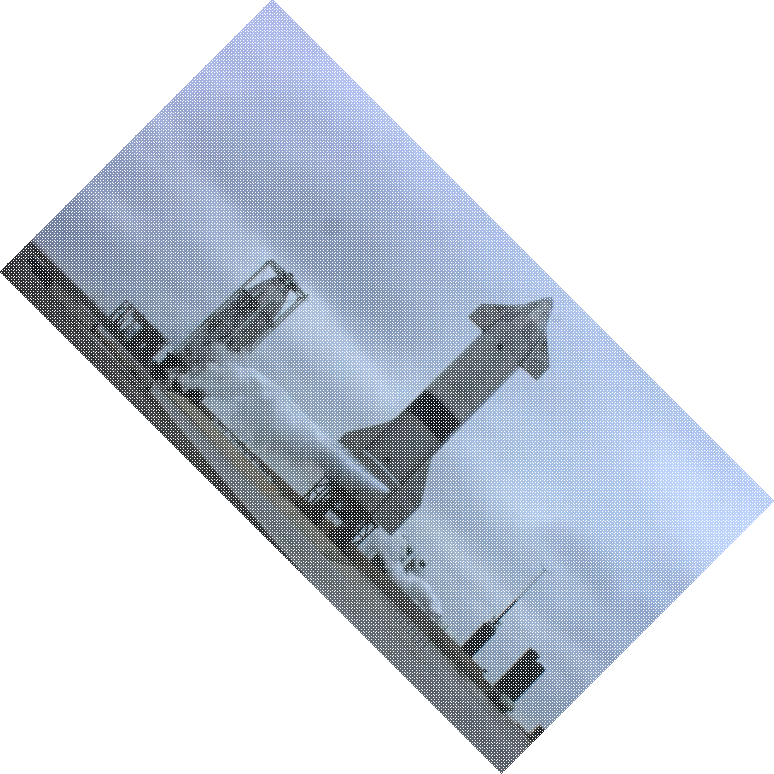

In [17]:
rot_im = rotate(original_img, 45)
rot_im

### La rotazione ora è corretta ma l'immagine presenta del rumore piuttosto regolare dovuto al fatto che certi punti vengono calcolati e risulteranno valori in virgola mobile, ma i pixel possono avere solo valori interi e quindi non verranno settati. 
### Per risolvere il problema bisogna trovare un modo di calcolare un valore di tali pixel in base a quelli vicini. 

Ci sono vari metodi, in questo caso useremo l'interpolazione bilineare. 

In pratica calcoleremo i valori dei pixel in base a quelli confinanti tramite questa combinazione lineare: 

$ f(x,y) \approx f(0,0)(1-\Delta x)(1-\Delta y)+f(1,0)\Delta x(1-\Delta y)+f(0,1)(1-\Delta x)\Delta y+f(1,1)\Delta x\Delta y $

Ed ecco una visualizzazione geometrica dell'interpolazione bilineare:

<img src="./img/bilinear_inter.svg" alt="drawing" width="300"/>

Prima di interpolare però dobbiamo invertire il processo di rotazione scorrendo sulle dimensioni della nuova cornice e non rispetto alle dimensioni dell'immagine non ruotata, poichè i pixel "spenti" sono si dovuti al problema del calcolo, ma quest'ultimo è dovuto dal fatto che un'immagine può essere vista come una matrice (in questo caso 4 sovrapposte RGBA), dove comunque idealmente dentro ogni cella ci sarà il valore del pixel in quel punto; Però ruotando un punto questo potrà dover essere messo, in teoria, tra due celle di questa matrice e qui sorge il problema del valore calcolato in virgola mobile e quindi la visualizzazione di buchi.

<!-- ![Alt Text](image path "title") -->
![Alt Text](./img/rot_es.png "Optional Title")



In [18]:
def backRotate(img,angle):

	beta = math.radians(angle)
	cos = math.cos(beta)
	sin = math.sin(beta)

	newWidth = int(img.width * cos + img.height * sin)
	newHeight = int(img.width * sin + img.height * cos)

	desImg = Image.new(img.mode,(newWidth,newHeight))
 
	rotationMatrix = [[np.cos(beta),-np.sin(beta),0],[np.sin(beta),np.cos(beta),0],[0,0,1]]
	translationMatrix = [[1,0,-img.width/2], [0,1,-img.height/2], [0,0,1]]
	convertMatrix = np.dot(rotationMatrix,translationMatrix)

	#si fa l'inversa della matrice poichè cambiamo il riferimento quindi cambiamo i segni
	#la rotazione e la traslazione saranno per l'appunto all'inverso
	convertMatrix_inv = np.linalg.inv(convertMatrix)
	
	#scorriamo rispetto alla nuova cornice
	for x in range(newWidth):
		for y in range(newHeight): 
			pos = [int(x-newWidth/2) , int(y-newHeight/2) ,1]
			originPos = np.dot(convertMatrix_inv,pos)

			if (img.width >  originPos[0] + 1 and img.height >  originPos[1] + 1) and (originPos>=0).all():
				
				x_low = np.floor(originPos[0])
				x_up = np.ceil(originPos[0])
				y_low = np.floor(originPos[1])
				y_up = np.ceil(originPos[1])
 
				d_x = originPos[0] - x_low
				d_y = originPos[1] - y_low
				
				p1 = np.array(img.getpixel((x_low,y_low)))
				p2 = np.array(img.getpixel((x_up,y_low)))
				p3 = np.array(img.getpixel((x_low,y_up)))
				p4 = np.array(img.getpixel((x_up,y_up)))

				#interpolazione
				colorReal = np.array((1-d_x)*(1-d_y)*p1+(1-d_x)*d_y*p3+(1-d_y)*d_x*p2+d_x*d_y*p4,dtype="int")
				desImg.putpixel((x,y),tuple(colorReal))
				
	return desImg

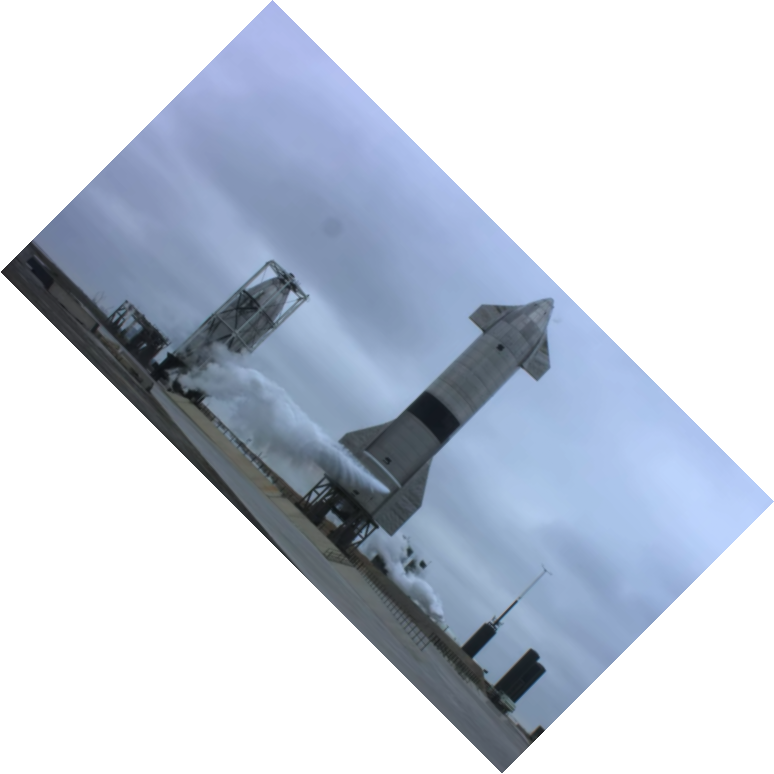

In [19]:
t0_rot = time.perf_counter()
rot_im = backRotate(original_img, 45)
t1_rot = time.perf_counter()
time_my_rot = t1_rot - t0_rot
rot_im

# Ingrandimento

Scalando l'immagine potremmo ingrandirla mettendo come fattori di scala numeri maggiori di 1, in questo caso come per la rotazione non dovremmo fare altro che moltiplicare ogni punto della nostra immagine originale con una matrice di rotazione, che in questo caso è la seguente:

$ \begin{bmatrix} x'\\y'\\1\\ \end{bmatrix} = $
$ \begin{bmatrix} sx & 0 & 0\\ 0 & sy & 0\\ 0 & 0 & 1\\ \end{bmatrix} $
$ \begin{bmatrix} x\\y\\1\\ \end{bmatrix} $

Dove sx e sy sono i due fattori di scala che appunto dovranno essere > 1

In [20]:

def Scale(img,sx,sy):

	desImg = Image.new(img.mode,(int(img.width * sx),int(img.height *sy)))
	convertMatrix = [[sx,0,0],[0,sy,0],[0,0,1]]

	for x in range(img.width):
		for y in range(img.height):
			color = img.getpixel((x,y))
			pos = [x,y,1]
			pos_convert = np.dot(convertMatrix,pos)

			desImg.putpixel((int(pos_convert[0]),int(pos_convert[1])),color)

	return desImg

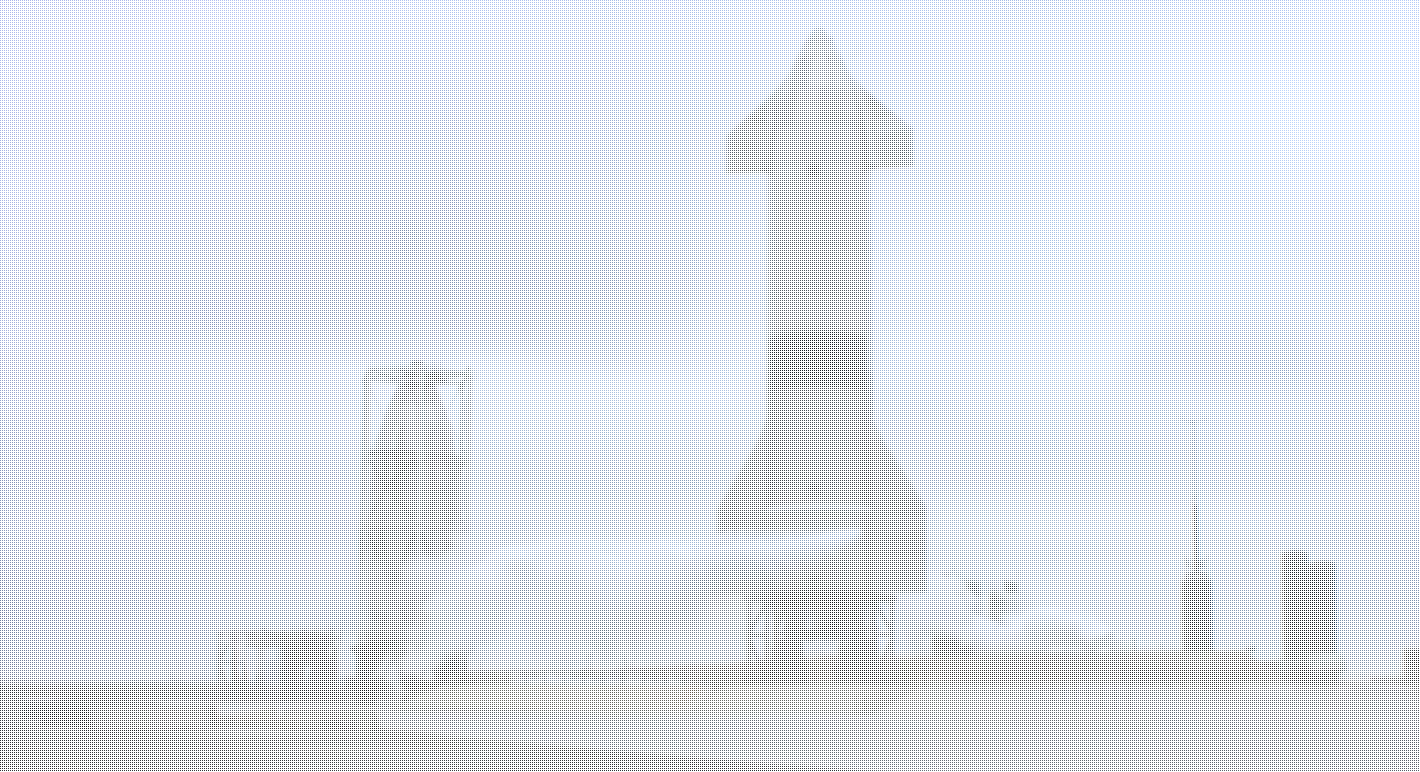

In [21]:
scal_im = Scale(original_img, 2, 2)
scal_im

### Anche nell'ingrandimento come nella rotazione, per motivi analoghi avremmo del ruome sempre per colpa di numeri in virgola mobile e quindi non rappresentabili come intensità di pixel, per risolvere basta interpolare nuovamente.

In [22]:
def backScale(img,sx,sy):
    desImg = Image.new(img.mode,(int(img.width * sx),int(img.height *sy)))
    convertMatrix = [[sx,0,0],[0,sy,0],[0,0,1]]
    convertMatrix_inv = np.linalg.inv(convertMatrix)
    for x in range(int(img.width * sx)):
        for y in range(int(img.height *sy)):
            pos  = [x,y,1]
            originPos = np.dot(convertMatrix_inv , pos)
            
            if (img.width >=  originPos[0] + 1 and img.height >=  originPos[1] + 1) and (originPos>=0).all():
                x_low = np.floor(originPos[0])
                x_up = np.ceil(originPos[0])
                y_low = np.floor(originPos[1])
                y_up = np.ceil(originPos[1])

                d_x = originPos[0] - x_low
                d_y = originPos[1] - y_low
				
                p1 = np.array(img.getpixel((x_low,y_low)))
                p2 = np.array(img.getpixel((x_up,y_low)))
                p3 = np.array(img.getpixel((x_low,y_up)))
                p4 = np.array(img.getpixel((x_up,y_up)))

                colorReal = np.array((1-d_x)*(1-d_y)*p1+(1-d_x)*d_y*p3+(1-d_y)*d_x*p2+d_x*d_y*p4,dtype="int")
                desImg.putpixel((x,y),tuple(colorReal))

    return desImg

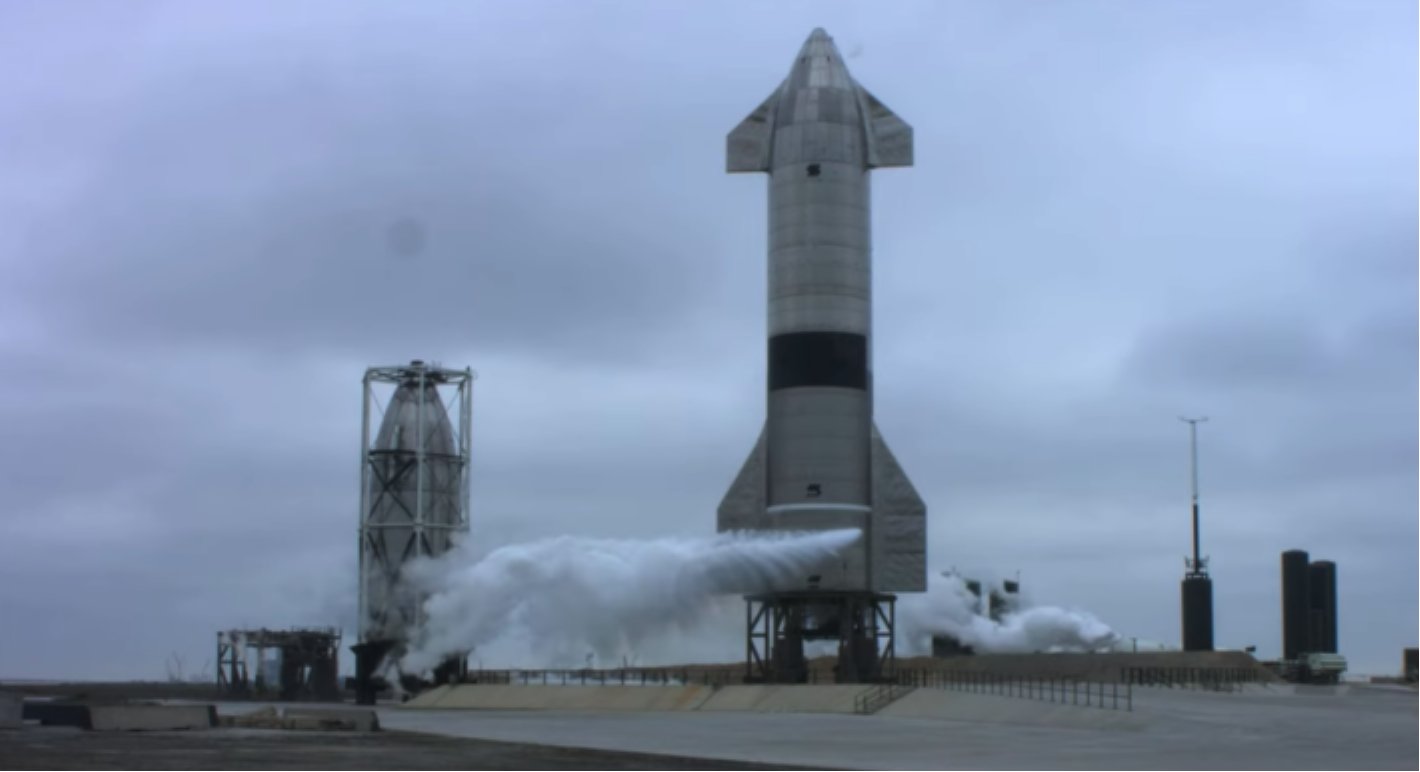

In [23]:
t0_scal = time.perf_counter()
scal_im = backScale(original_img, 2, 2)
t1_scal = time.perf_counter()
time_my_scal = t1_scal - t0_scal
scal_im

## Ma ora mettiamo a confronto le nostre funzioni con quelle della libreria per image processing pillow

### Partiamo dalla rotazione, alla funzione passiamo tre parametri: angolo, tipo di algoritmo per togliere il rumore e l'opzione expand che creae una cornice più grande, come facciamo noi

L'angolo ha un meno semplicemente perchè di default ruota nella direzione opposta rispetto alla nostra funzione, ovviamente abbiamo scelto anche qui l'interpolazione bilineare e almeno ad occhio direi che le due immagini sono del tutto confrontabili

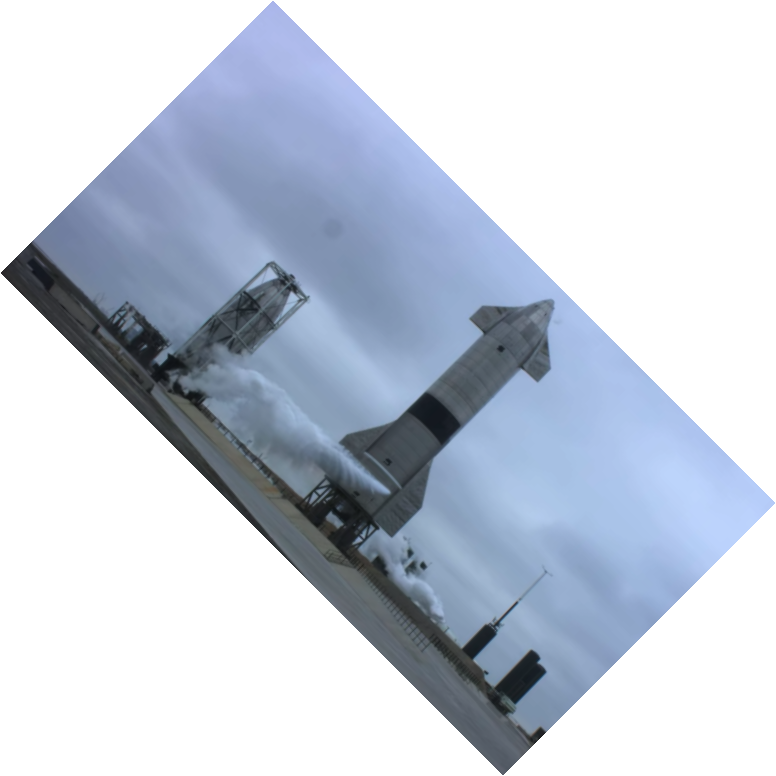

In [24]:
t0_rot = time.perf_counter()
rotated = original_img.rotate(-45, resample=Image.BILINEAR, expand=True)
t1_rot = time.perf_counter()
time_pil_rot = t1_rot - t0_rot
rotated

### Di seguito per prova usiamo l'interpolazione bicubica che dovrebbe fare un lavoro migliore perdendo leggermente in performance ma su questa immagine il risultato è assolutamente confrontabile

## L'interpolazione bicubica è l'equivalente in 2D dell'interpolazione spline

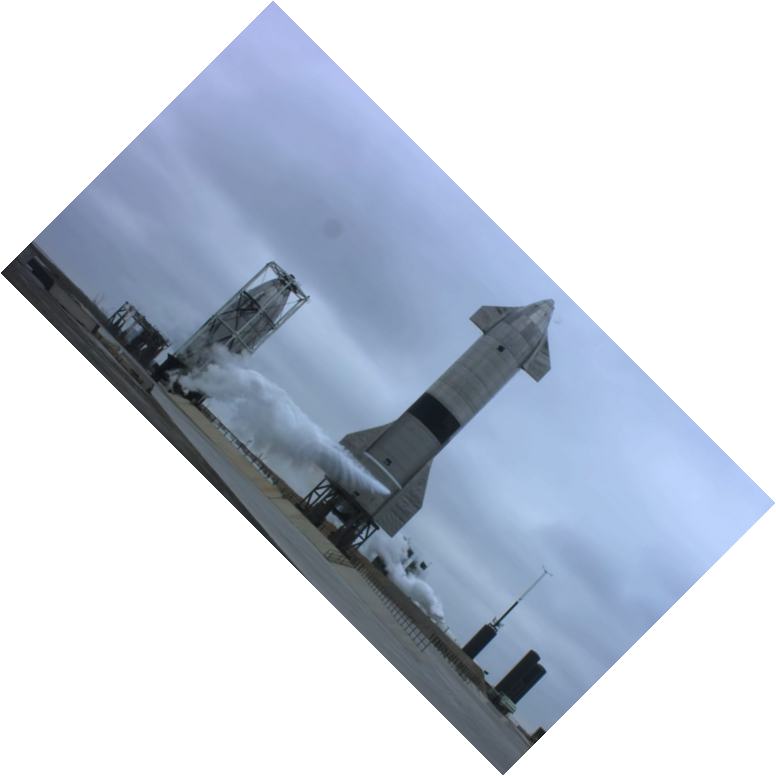

In [25]:
rotated = original_img.rotate(-45, resample=Image.BICUBIC, expand=True)
rotated

### Ora vediamo il confronto con il ridimensionamento, i parametri sono le nuove dimensioni messe all'interno di una tupla e il tipo di algoritmo per la cancellazione del rumore che anche in questo caso sarà un'interpolazione bilineare

Nella nostra funzione si dovevano inserire i fattori di scala, qui invece direttamente le nuove dimensioni (che ovviamente coincidono) ed anche qui i risultati sono del tutto confrontabili



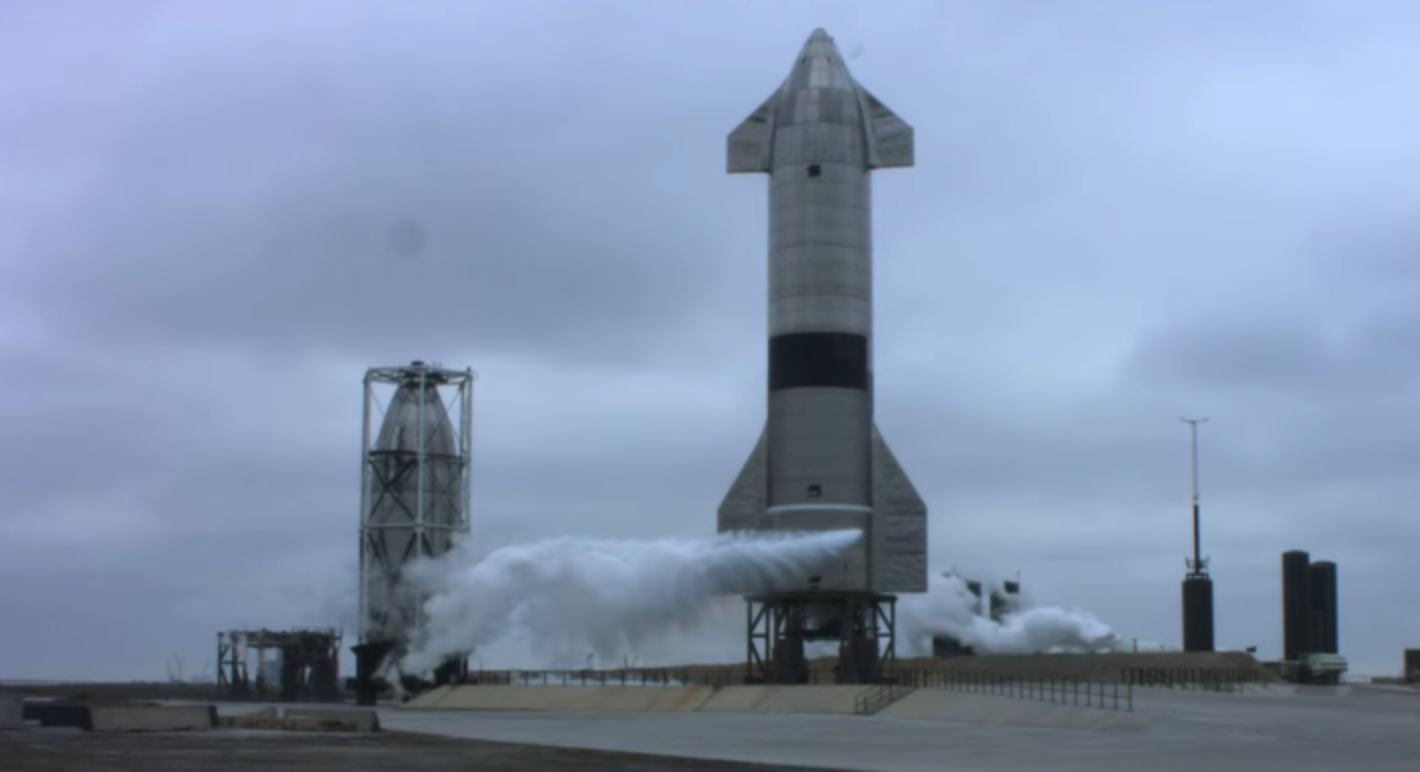

In [26]:
t0_scal = time.perf_counter()
scaled = original_img.resize((1420, 772), resample=Image.BILINEAR)
t1_scal = time.perf_counter()
time_pil_scal = t1_scal - t0_scal
scaled

### Anche per il metodo resiz usando l'interpolazione bicubica i risultati sono del tutto simili

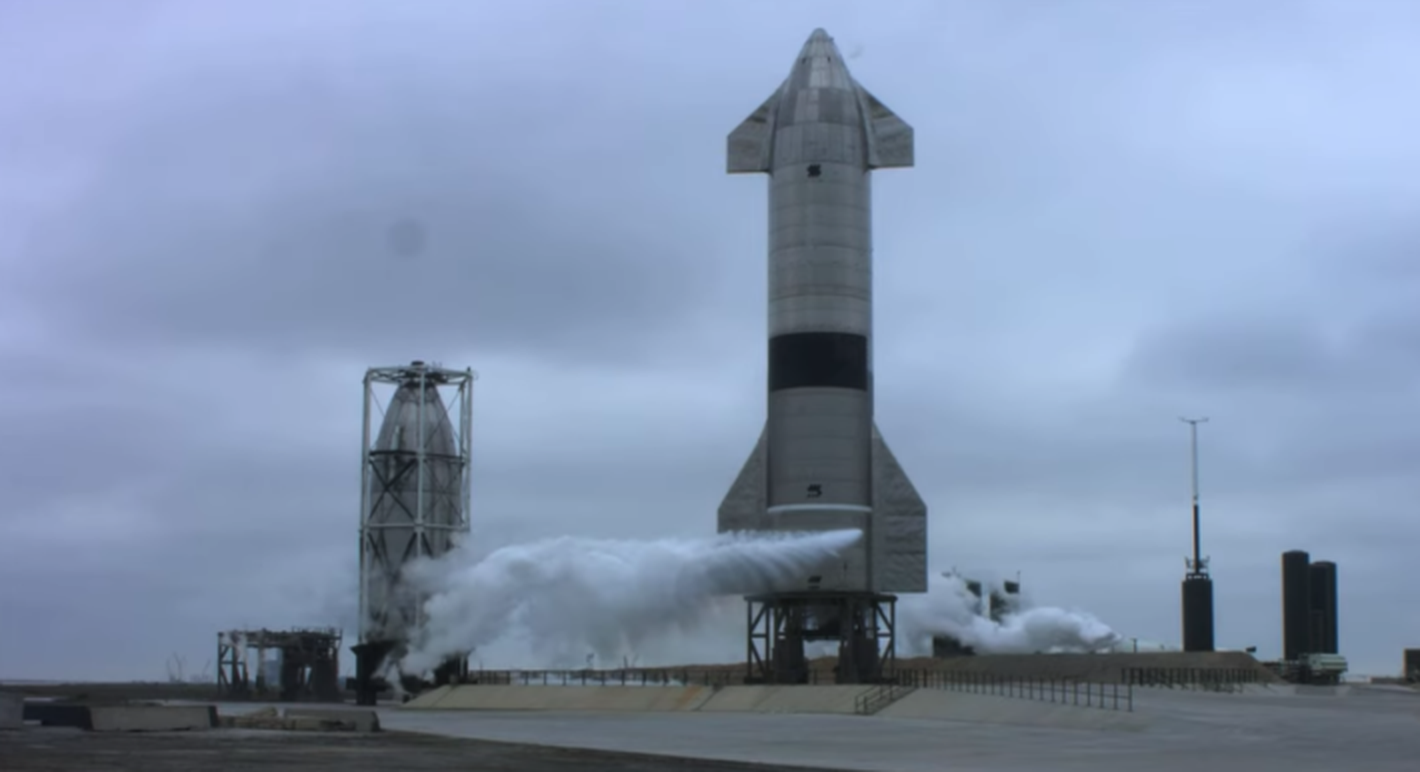

In [27]:
scaled = original_img.resize((1420, 772), resample=Image.LANCZOS)
scaled

## Conclusioni

#### L'implementazione di funzioni che permettono la rotazione e lo zoom di un immagine in questo caso avevano esclusivamente uno scopo didattico, vedere che i risultati sono del tutto confrontabili mi ha sorpreso ma ovviamente le rispettive funzioni della libreria pillow permettono più controllo come la scelta dellàalgoritmo per togliere il rumore in base ai casi (performance o qualità), ma sopratutto a parità di algoritmo le nostre funzioni sono nettamente meno performamnti.

### Di seguito il confronto dei tempi espressi in secondi


In [28]:
print("Time in seconds\n")
print("my rotation time:", time_my_rot, "  pillow rotation time:", time_pil_rot)
print("my scale time:", time_my_scal, "  pillow scale time:", time_pil_scal)

Time in seconds

my rotation time: 15.023093200000005   pillow rotation time: 0.024103599999989456
my scale time: 49.750741800000014   pillow scale time: 0.029859499999986383
